# ___

# [ Machine Learning in Geosciences ]

**Department of Applied Geoinformatics and Carthography, Charles University** 

*Lukas Brodsky lukas.brodsky@natur.cuni.cz*

    
___


## End-to-End Machine Learning Project Workflow  Elements

This notebook demonstrates the elements of the ML workflow by Python code snippets. These snippets are mosly independent each other using different datasets. The goal is to illustrate examples in the workflow. 

1. Task description 
2. Exploratory Data Analysis (EDA) 
3. Data preparation 
4. Select and train model 
5. Model fine-tuning 
6. Results interpretation


In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from scipy.stats import randint
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.utils import resample
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle


# data 
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification

import geopandas as gpd

import matplotlib.pyplot as plt 
# %matplotlib inline
import contextily as cx

## 1.1. Task description

### 1.1. Task description example - Frame the problem 

Objective: Demonstrate ML project workflow elemets as a systematic approach to model development & evaluation 

Data: Simulated

Constraints: Each element is presented independently others, so the workflow is not linked!. 

Performance Measure: exploring many of them


## 1.2. Select the performance measures

### Problem: regression -> MAE or MSE? 

Key Differences

- **MAE (Mean Absolute Error)**: Measures the average absolute difference between predicted and actual values. It **treats all errors equally**.

- **MSE (Mean Squared Error)**: **Squares the errors before averaging**, which **penalizes large errors** more than small ones.

When to Use MAE Instead of MSE? 

**Mean Absolute Error (MAE)**

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
**Description:**
- Measures the average absolute difference between predicted and actual values.
- **Less sensitive to outliers than MSE**.

**Variables:**
- **n** = Number of samples
- **y_i** = Actual value
- **\hat{y}_i** = Predicted value

---

**Mean Squared Error (MSE)**
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
**Description:**
- Squares the errors, giving more weight to large errors.
- **More sensitive to outliers than MAE**.


In [ ]:
# Data: 

# Simulated true values 
y_true = np.array([200, 250, 300, 350, 400, 450, 500])

# Two different models with different errors
y_pred_good = np.array([210, 260, 290, 340, 410, 460, 490])  # Small errors
y_pred_bad = np.array([150, 300, 500, 700, 200, 600, 800])   # Large errors (outliers)

In [ ]:
# Compute MAE and MSE
mae_good = mean_absolute_error(y_true, y_pred_good)
mse_good = mean_squared_error(y_true, y_pred_good)

mae_bad = mean_absolute_error(y_true, y_pred_bad)
mse_bad = mean_squared_error(y_true, y_pred_bad)

In [ ]:
# Print the results
print(f"Good Model:  MAE = {mae_good:.2f}, MSE = {mse_good:.2f}")
print(f"Bad Model:   MAE = {mae_bad:.2f}, MSE = {mse_bad:.2f}")

In [ ]:
# Visualizing the Errors
plt.figure(figsize=(8, 5))
plt.plot(y_true, y_true, "go-", label="True Values")  # Perfect fit
plt.plot(y_true, y_pred_good, "bo-", label="Good Model Predictions")
plt.plot(y_true, y_pred_bad, "ro-", label="Bad Model Predictions")
plt.legend()
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Comparison of Predictions")
plt.show()

####  Explanation: 

For the good model: MAE and MSE are both small.

For the bad model:
- MAE provides a stable measure of error.
- MSE is much higher because it heavily penalizes large errors due to squaring.

MAE or MSE?
- Use MAE when you want a metric that is robust to outliers.
- Use MSE when you want to heavily penalize large errors.

-----------

### Classification problem 

<div>
    <img src="attachment:image.png" width="300"/>
</div>



### Overall accuracy or F1-score? 

Key Differences

- **Overall Accuracy (OA)**: Measures the **percentage of correct predictions** but can be misleading when data is imbalanced.

- **F1-score**: The **harmonic mean of Precision and Recall**, useful when class imbalance exists.


**The metrics:**

lassification and Regression Metrics

**Accuracy (Overall Accuracy - OA)** 

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Description:**
- Measures the proportion of correctly classified instances.
- **Best for balanced datasets** but can be misleading for imbalanced data.

**Variables:**
- **TP** = True Positives (Correctly classified positive cases)
- **TN** = True Negatives (Correctly classified negative cases)
- **FP** = False Positives (Incorrectly classified negative as positive)
- **FN** = False Negatives (Incorrectly classified positive as negative)

---

**Precision (Positive Predictive Value)** 
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Description:**
- Measures how many predicted positive cases were actually positive.
- **Useful when false positives should be minimized** (e.g., anomaly, change detection).

---

**Recall (Sensitivity or True Positive Rate)** 
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
**Description:**
- Measures how many actual positive cases were correctly identified.
- **Useful when false negatives should be minimized** (e.g., medical diagnoses).

---

**F1-score (Harmonic Mean of Precision and Recall)**

The harmonic mean is a type of average that is particularly useful when dealing with rates or ratios. In the context of the F1 score, it is used to balance Precision and Recall.

$$
\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

The harmonic mean ensures that the F1 score is low when either Precision or Recall is low—meaning that it only gives a high score when both metrics are high.

**Description:**
- **Balances Precision and Recall**, useful for imbalanced datasets.
- **Prevents Overemphasis on Extreme Values**
- A **high F1-score** indicates both good Precision and Recall.

Case 1: One value is very small, the other is large. Suppose P=1.0 and R=0.1. 
    
    Aritmetic mean = 0.55 
    Harmonic mean = 0.1818

Case 2: Both values are equal. Suppose P=R=0.8.
    
    Aritmetic mean = 0.8 
    Harmonic mean = 0.8

Case 3: One value is zero. Suppose P=1.0 and R=0.0.
    
    Aritmetic mean = 0.5 
    Harmonic mean = 0.0

In [ ]:
# Simulate an imbalanced dataset (95% non-fraud, 5% fraud)
np.random.seed(42)
n_samples = 1000

# 95% Class 0 (Non-change) and 5% Class 1 (Anomaly)
y = np.concatenate([np.zeros(int(n_samples * 0.95)), np.ones(int(n_samples * 0.05))])
X = np.random.randn(n_samples, 5)  # Random features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Train a simple classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

In [ ]:
# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
# Print results
print(f"Overall Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

In [ ]:
# Visualizing Class Distribution
plt.figure(figsize=(6, 4))
plt.bar(["No-change (Class 0)", "Anomaly (Class 1)"], [np.sum(y == 0), np.sum(y == 1)], color=['blue', 'red'])
plt.title("Imbalanced Dataset Distribution")
plt.ylabel("Number of Samples")
plt.show()

#### Explanation: 

- Overall Accuracy is high (~95%) but misleading—this is because the model can always predict "Non-change" and still achieve 95% accuracy!

- F1-score is ZERO, reflecting the fact that the model fails to detect the anomaly (high recall is needed).


When to Use F1-score Instead of OA? 

- Use OA when classes are balanced (e.g., 50-50 split).
- Use F1-score when one class is much rarer than the other to ensure both Precision & Recall are optimized.

*Note: see later the use of SMOTE!* 

### Micro, Macro, and Weighted Averages in Classification Metrics

These methods come into play when dealing with **multi-class or imbalanced datasets**.

When to use which?


#### **1. Micro Average**
The **Micro Average** **aggregates the contributions of all classes** to compute the **global** precision, recall, and F1-score.

#### **Formulation:**
$$
\text{Precision}_{\text{micro}} = \text{Recall}_{\text{micro}} = \frac{\sum_{i=1}^{N} TP_i}{\sum_{i=1}^{N} (TP_i + Fx_i)}
$$

$$
\text{F1-score}_{\text{micro}} = \frac{2 \times \sum_{i=1}^{N} TP_i}{2 \times \sum_{i=1}^{N} TP_i + \sum_{i=1}^{N} FP_i + \sum_{i=1}^{N} FN_i}
$$

Where:
- \( TP_i \) = True Positives for class \( i \)
- \( FP_i \) = False Positives for class \( i \)
- \( FN_i \) = False Negatives for class \( i \)
- \( N \) = Number of classes

---

#### **2. Macro Average**
The **Macro Average** computes the metric **independently for each class** and then takes the average.

#### **Formulation:**
$$
\text{Precision}_{\text{macro}} = \frac{1}{N} \sum_{i=1}^{N} \text{Precision}_i
$$

$$
\text{Recall}_{\text{macro}} = \frac{1}{N} \sum_{i=1}^{N} \text{Recall}_i
$$

$$
\text{F1-score}_{\text{macro}} = \frac{1}{N} \sum_{i=1}^{N} \text{F1-score}_i
$$

Where:
$$
\text{F1-score}_i = \frac{2 \times \text{Precision}_i \times \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
$$

---

#### **3. Weighted Average**
The **Weighted Average** **considers the number of instances** in each class when computing the average.

#### **Formulation:**
$$
\text{Precision}_{\text{weighted}} = \sum_{i=1}^{N} w_i \times \text{Precision}_i
$$

$$
\text{Recall}_{\text{weighted}} = \sum_{i=1}^{N} w_i \times \text{Recall}_i
$$

$$
\text{F1-score}_{\text{weighted}} = \sum_{i=1}^{N} w_i \times \text{F1-score}_i
$$

Where the weight \( w_i \) is defined as:
$$
 w_i = \frac{TP_i + FN_i}{\sum_{j=1}^{N} (TP_j + FN_j)}
$$

This ensures that the contribution of each class is proportional to its actual frequency in the dataset.

---

### **Explanation**
- **Micro Average** is useful when there is **class imbalance** and focuses on **overall performance**.
- **Macro Average** treats all **classes equally**, regardless of their frequency.
- **Weighted Average** accounts for class imbalance by giving more **importance to frequent classes**.


-------

### Area Under the Receiver Operating Characteristic Curve (ROC-AUC) 

The AUC-ROC curve is an essential tool used for evaluating the performance of binary classification models. It plots the **True Positive Rate (TPR) against the False Positive Rate (FPR) at different thresholds** showing how well a model can distinguish between two classes such as positive and negative outcomes.

It provides a graphical representation of the model’s ability to distinguish between two classes like **positive class for presence of a disease** and **negative class for absence of a disease**.


The AUC is calculated as the area under the ROC curve, which is constructed by plotting the True Positive Rate (TPR) vs. False Positive Rate (FPR) at different thresholds: 
$$
AUC = \sum_{i=1}^{n-1} (FPR_{i+1} - FPR_i) \times \frac{TPR_{i+1} + TPR_i}{2}
$$

where:


**Terms**

- **TPR (True Positive Rate)**: The ratio of correctly predicted positive instances.
- **FPR (False Positive Rate)**: The ratio of incorrectly predicted negative instances.

$$\frac{FP}{FP + TN}$$

**Explanation:**
- Measures how well the model separates positive and negative classes.
- **Higher AUC = Better classification performance**.
- ROC Curve: ROC Curve plots TPR vs. FPR at different thresholds. **It represents the trade-off between the sensitivity and specificity** of a classifier.
- AUC (Area Under the Curve): An AUC value of 1.0 indicates perfect performance while 0.5 suggests it is random guessing.
- AUC-ROC is effective when the dataset is balanced and the model **needs to be evaluated across all thresholds**.

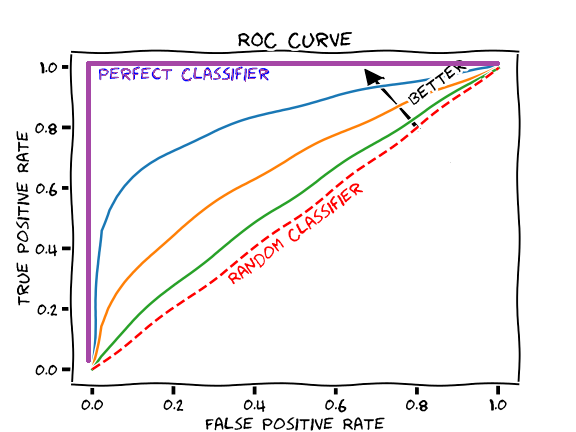

In [ ]:
# Case of imbalanced dataset (95% non-change, 5% anomaly)
np.random.seed(42)
n_samples = 1000

X = np.random.randn(n_samples, 5)  # 5 random features
y = np.concatenate([np.zeros(int(n_samples * 0.95)), np.ones(int(n_samples * 0.05))])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Train a simple classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
# Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # probability scores 

In [ ]:
# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Print results
print(f"Accuracy: {accuracy:.2f}")      # Can be misleading for imbalanced data
print(f"ROC-AUC Score: {roc_auc:.2f}")  # Better metric for imbalanced data

In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Anomaly Detection")
plt.legend()

**Explanation**

- Accuracy may be misleading: The model might predict "Non-change" for most cases and still get high accuracy (~95%).
- ROC-AUC Score is more informative: It considers different probability thresholds and evaluates how well the model distinguishes between anomaly and non-change.

ROC Curve Interpretation:

- Closer to (0,1) → Better Model

- Diagonal Line → Random Guessing

- Higher AUC = Better Classification Performance
 
**Use ROC-AUC when evaluating classifiers on imbalanced datasets to avoid misleading accuracy scores.**

In [ ]:
# Example 2: Random Forest vs. Logistic regression
X, y = make_classification(
    n_samples=1000, n_features=20, n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

In [ ]:
y_pred_logistic = logistic_model.predict_proba(X_test)[:, 1]
y_pred_rf = random_forest_model.predict_proba(X_test)[:, 1]


In [ ]:
test_df = pd.DataFrame(
    {'True': y_test, 'Logistic': y_pred_logistic, 'RandomForest': y_pred_rf})

In [ ]:
plt.figure(figsize=(7, 5))

for model in ['Logistic', 'RandomForest']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()


### Multi-class classification problem
The general steps for using AUC-ROC in the context of a multiclass classification model are:

**One-vs-All Methodology**:
- For each class in your multiclass problem, treat it as the positive class while combining all other classes into the negative class.
- Train the binary classifier for each class against the rest of the classes.

**Calculate AUC-ROC for Each Class**:
- Plot the ROC curves for each class on the same graph. Each curve represents the discrimination performance of the model for a specific class.
- Examine the AUC scores for each class. A higher AUC score indicates better discrimination for that particular class.


Here the plot of the ROC curve is for the given class against the rest (Logistic Regressiona and Random Forest).
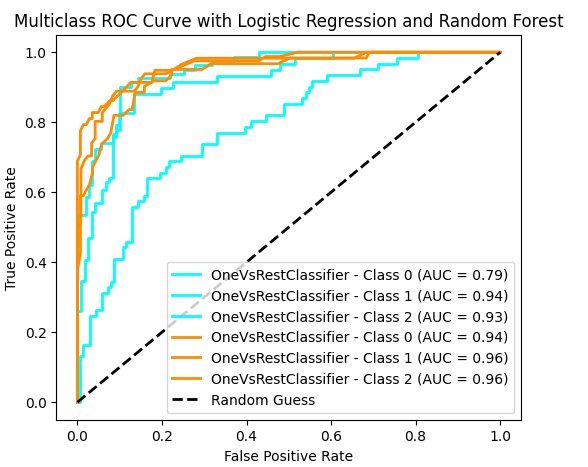

---

## 2. Exploratory Data Analysis (EDA)

* Visualizing the data 
* Looking for correlations
* Experiment with attributes 


### Example: Meuse dataset 
This data set gives locations and topsoil heavy metal concentrations, along with a number of soil and landscape variables at the observation locations, collected in a flood plain of the river Meuse, near the village of Stein (NL). Heavy metal concentrations are from composite samples of an area of approximately 15 m x 15 m.

Dataset meuse is a popular geostatistical dataset published as part of the 'sp' package of R statistical software under the GPL v3 license and maintained by Edzer Pebesma. This is pure copy of the dataset to make it available not only within R-project.

Credits to the dataset: the Authors of the 'sp' package. http://cran.r-project.org/web/packages/sp/index.html

Please se also: https://rsbivand.github.io/sp/reference/meuse.html.

In [ ]:
# Spatial data example (Meuse river data set)
url = 'https://raw.githubusercontent.com/lbrodsky/meuse/main/meuse.txt'
meuse = pd.read_csv(url)

In [ ]:
meuse = gpd.GeoDataFrame(
    meuse, geometry=gpd.points_from_xy(meuse['x'], meuse['y']))
meuse['geometry'].head()

In [ ]:
# https://rsbivand.github.io/sp/reference/meuse.html epsg:28992
meuse = meuse.set_crs('epsg:28992')

In [ ]:
# meuse.crs
meuse_wm = meuse.to_crs(epsg=3857)

In [ ]:
meuse.head()

In [ ]:
# meuse['cadmium']

#### Plot the sample data (Cadmium) in a map 

In [ ]:
# import contextily as cx
ax = meuse_wm.plot(meuse_wm['dist'], markersize=meuse_wm['cadmium'] *10, alpha=0.9, figsize=(10,10), 
            legend=True, cmap=plt.get_cmap("plasma"))
# cx.add_basemap(ax)

In [ ]:
meuse_wm.info()

In [ ]:
meuse_wm.describe()

In [ ]:
# selected attributes
meuse_wm[["cadmium", "copper", "lead", "zinc", "elev", "dist", "om", "soil", "lime", "ffreq"]]

In [ ]:
meuse_corr = meuse_wm[["cadmium", "copper", "lead", "zinc", "elev", "dist", "om", "soil", "lime", "ffreq"]].corr()
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(meuse_corr, cmap="coolwarm", annot=True,  fmt=".1f", vmin=-1, vmax=1)

In [ ]:
# Pair-plot"copper", "lead", "zinc" with hue="cadmium"
sns.pairplot(meuse_wm[["cadmium", "elev", "dist", "om", "soil", "lime", "ffreq"]])

---

## 3. Data Preparation

Data preparation is a crucial step to ensure the quality and reliability of the model. This section focuses on feature engineering, which includes scaling, encoding categorical data, handling missing values, and splitting data correctly.

3.1. **Feature Engineering**
- Scaling: Normalization vs. Standardization
- Encoding categorical data: OneHotEncoder vs. Ordinal Encoder

3.2. **Handling Missing Data**
- Gap filling techniques (mean, interpolation, ML-based imputation)

3.3. **Splitting Data into Train/Test Sets**
- Random Sampling vs. Stratified Sampling (when to use each)
- Avoiding data leakage


### Scaling: Normalization and Standardization

Scaling numerical features is important for models sensitive to feature magnitudes, such as gradient-based algorithms (e.g., logistic regression, neural networks, k-NN, SVMs, etc.). When features have different units should be scaled to [0,1].

**Normalization (Min-Max Scaling)** 

Normalization scales values to a fixed range, usually **[0,1]**.

$$
X' = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

**Where:**  
- \( X' \) = normalized value  
- \( X \) = original value  
- \( X_{\min} \) = minimum value in the feature  
- \( X_{\max} \) = maximum value in the feature  

---

**Standardization (Z-Score Scaling)**
Standardization transforms data to have **zero mean** and **unit variance**.

$$
X' = \frac{X - \mu}{\sigma}
$$ 

**Where:**  
- \( X' \) = standardized value  
- \( X \) = original value  
- \( \mu \) = mean of the feature  
- \( \sigma \) = standard deviation of the feature  

---

Key Differences: 
- Affected by Outliers? Normalization: **Yes**, Standardization: **No** 
- When to Use? 

- Normalization when features have different units but similar importance. 
- Standardization when features follow a normal distribution. 


In [ ]:
# Data 
# Synthetic dataset (Elevation in meters, Temperature in °C)
np.random.seed(42)
elevation = np.random.randint(0, 4000, 100)   # Elevation in meters
temperature = np.random.randint(-10, 35, 100) # Temperature in °C

# Binary classification: 1 = Snow, 0 = No Snow
y = np.array([1 if e > 3000 or t < 0 else 0 for e, t in zip(elevation, temperature)])

# Stack features
X = np.column_stack((elevation, temperature))

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
# Model without scaling
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_unscaled = accuracy_score(y_test, y_pred)

In [ ]:
# Model with Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=3)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

In [ ]:
print(f"Accuracy without Scaling: {accuracy_unscaled:.2f}")  # Likely low
print(f"Accuracy with Standardization: {accuracy_scaled:.2f}")  # Higher

### Encoding Categorical Data: OneHotEncoder vs. OrdinalEncoder

**One-Hot Encoding (OHE)**

- Converts categorical values into binary vectors.
- Each category gets a separate column (good for non-ordinal categories).

**Ordinal Encoding**

- Assigns integer values to categories (good for ordinal features).

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# categories
colors = np.array([["Red"], ["Green"], ["Blue"], ["Red"], ["Blue"]])

In [ ]:
# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_colors = encoder.fit_transform(colors)

In [ ]:
encoder.categories_

In [ ]:
# Show results
print("Original Categories:\n", colors.ravel())
print("\nOne-Hot Encoded Matrix:\n", encoded_colors)

### Handling Missing Data

Handling missing values properly prevents biased or incorrect model outputs.

Gap Filling Techniques:

1. Mean/Median Imputation: Suitable for small missing values in numerical data.


`imputer = SimpleImputer(strategy='mean'); X_filled = imputer.fit_transform(X)`


2. Interpolation: Uses linear, polynomial, or time-series methods.

3. ML-Based Imputation (KNN, Iterative Imputer): uses machine learning to predict missing values.

`
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
X_filled = imputer.fit_transform(X)
`

#### Data imputing

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

In [ ]:
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(X)

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X)
SimpleImputer()

In [ ]:
print(imp_mean.transform(X))

### Splitting Data into Train/Test Sets

1. **Random Sampling** (default in train_test_split()):  may result in an unequal class distribution in train and test sets.
 

2. **Stratified Sampling**: ensures that both sets maintain the same class proportions.
Use when the dataset is imbalanced (e.g., fraud detection, medical diagnosis).

In [ ]:
# Example: stratified samplig 
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000, n_features=20, n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Avoiding Data Leakage

Data Leakage happens when information from outside the training dataset is used to build the model, leading to overfitting.

1. **Leaking Target Information into Features**: 
    Example: Using a feature that contains future information (e.g., using a "Payment Completed" column to predict fraud before the payment is processed).

2. **Scaling/Encoding Before Splitting**: 

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Wrong! Applied before train-test split

In [ ]:
# Corrected: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform, not fit_transform!

3. **Using Entire Dataset for Feature Selection Before Splitting**


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)  # Causes leakage!

In [ ]:
# Correct: 
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)  # Avoids leakage!

### Summary data preparation: 
- Scaling: Normalization is used when features have different units but similar importance. Standardization is used when features follow a normal distribution. 
- Encoding: One-Hot for nominal, Ordinal for ordered categories. 
- Missing Data: mean for small gaps, Interpolation for time-series, ML-based for complex cases. 
- Splitting Data: stratified sampling for imbalanced datasets. 
- Avoiding Leakage: always apply transformations after splitting data! 

## 4. Select & Train Model

**Suggestions**: 
- Always start with a simple model (baseline).
- Check linearity before selecting models.
- Take care of bias-variance tradeoff, adjust model complexity. 
- Potentially use learning & validation curves in case of iterative learning algorithm. 

## 5. Model Fine-Tuning

### Grid Search vs. Randomized Search

Grid Search exhaustively searches through a predefined hyperparameter grid. 

Randomized Search selects random combinations of hyperparameters to find the best model efficiently.

In [ ]:
# Load data
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

In [ ]:
# Grid Search with Random Forest

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20], # Depth of trees
    'min_samples_split': [2, 5, 10], # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]    # Minimum samples per leaf
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Print best parameters
print("Best Parameters (Grid Search):", grid_search.best_params_)

In [ ]:
# Randomized Search with Random Forest
# [None, 10, 20, 30, 50]

# Define hyperparameter distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': (2, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Perform Randomized Search
random_search = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

In [ ]:
# Print best parameters
print("Best Parameters (Randomized Search):", random_search.best_params_)

**Which One to Use?** 

    Grid Search is useful when the parameter space is small and you want the most precise tuning.

    Randomized Search is better for large parameter spaces because it is computationally efficient.


In [ ]:
print(grid_search.best_score_, random_search.best_score_)

### K-Fold & Stratified K-Fold

In [ ]:
# Create a Classification Dataset
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, 
                           weights=[0.7, 0.3], random_state=42)  # Slightly imbalanced

In [ ]:
# Define the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# K-Fold Cross-Validation (Standard)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print("K-Fold Cross-Validation Results:")
print("Individual Fold Accuracies:", kf_scores)

In [ ]:
# Step 4: Stratified K-Fold Cross-Validation (For Imbalanced Data)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("\n Stratified K-Fold Cross-Validation Results:")
print("Individual Fold Accuracies:", skf_scores)

In [ ]:
plt.plot(kf_scores, label='K-Fold')
plt.plot(skf_scores, label='StartifiedK-Fold')
plt.legend()

If the dataset is balanced, K-Fold and Stratified K-Fold give similar results.

If the dataset is imbalanced, Stratified K-Fold provides more reliable results by ensuring class proportions in each fold.

### Handling Imbalanced Datasets
**SMOTE (Synthetic Minority Oversampling Technique)**

In [ ]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)

In [ ]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    plt.legend()

In [ ]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
# summarize the new class distribution
counter = Counter(y)
print(counter)

In [ ]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [ ]:
# Classification with SMOTE

In [ ]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

In this case, we can see a modest improvement in performance from a ROC AUC of about 0.76 to about 0.80.

### Why Adjust Class Weights?

* When dealing with imbalanced data, models tend to favor the majority class.

* Setting class_weight='balanced' helps give more importance to the minority class.

* Works well in Logistic Regression, Random Forest, etc. models.

In [ ]:
# Create an imbalanced Dataset
X, y = make_classification(n_samples=2000, n_features=10, n_classes=2, 
                           weights=[0.9, 0.1], random_state=42)  # 90% of one class!

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Model WITHOUT Class Weight Adjustment
rf_no_weights = RandomForestClassifier(random_state=42)
rf_no_weights.fit(X_train, y_train)
y_pred_no_weights = rf_no_weights.predict(X_test)

In [ ]:
# Train a Model WITH Class Weights Adjusted
rf_with_weights = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_with_weights.fit(X_train, y_train)
y_pred_with_weights = rf_with_weights.predict(X_test)

In [ ]:
# Print Accuracy & Classification Report
print("Model WITHOUT Class Weights Adjustment:")
print("Accuracy:", accuracy_score(y_test, y_pred_no_weights))
print("f1_score:", round(f1_score(y_test, y_pred_no_weights), 2))
print('---')
print("Model WITH Class Weights Adjustment:")
print("Accuracy:", accuracy_score(y_test, y_pred_with_weights))
print("f1_score:", round(f1_score(y_test, y_pred_with_weights), 2))


---

# 6. Results Interpretation

See presentation 